Enhancements:
- Include price that assets were bought into the state
- Explore neutral penalty
- Encoding layer to control/learn state representation
- Improve stability of learning algorithms through the use of PPO, SAC
- Create short-term endpoints for trading windows during training and shuffle these windows
- Feature selection and hyperparameter tuning through validation search [Discount rate, ]
- More sophistication for state-propagation, e.g. Recurrent NN, Transformer

TODO:
- Walk-forward validation training
- Test evaluation of all models
- Use trained value network and pretrained policy network?


Consider:
- Recreating the table on Slide 41 of 56 from this set of lecture slides would be good for our purposes https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf


In [9]:
import gym

In [11]:
env = gym.make("CartPole-v1")

In [13]:
int(None)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [12]:
env.step(0)

AssertionError: Cannot call env.step() before calling reset()

In [1]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

## Datasets

In [2]:
MONTH = 'jan'
datasets = []
dataset_scopes = ['minimal', 'minimal_window', 'full', 'full_window']
dataset_components = [
    'X_train.pt', 'X_validation.pt', 'X_test.pt',
    'y_train.pt', 'y_validation.pt', 'y_test.pt',
    'bid_train.pt', 'bid_val.pt', 'bid_test.pt',
    'ask_train.pt', 'ask_val.pt', 'ask_test.pt',
]

for dataset_scope in dataset_scopes:
    dataset = []
    for dataset_component in dataset_components:
        dataset.append("datasets/" + MONTH + "/" + dataset_scope + "/" + dataset_component)
    datasets.append(dataset)

In [8]:
datasets[0]

['datasets/jan/minimal/X_train.pt',
 'datasets/jan/minimal/X_validation.pt',
 'datasets/jan/minimal/X_test.pt',
 'datasets/jan/minimal/y_train.pt',
 'datasets/jan/minimal/y_validation.pt',
 'datasets/jan/minimal/y_test.pt',
 'datasets/jan/minimal/bid_train.pt',
 'datasets/jan/minimal/bid_val.pt',
 'datasets/jan/minimal/bid_test.pt',
 'datasets/jan/minimal/ask_train.pt',
 'datasets/jan/minimal/ask_val.pt',
 'datasets/jan/minimal/ask_test.pt']

## Reward function

State representation:

- At any current point we want to know our current portfolio
- The action is how we want to the new portfolio that we want, we will limit our portfolio (and hence actions) to -1, 0, and 1 quantity of the asset  
- We look at the next time step and get reward from the action we took

This neutral penalty seems to work: $0.0001 * 10^{epoch}$

Note that actions are:
- 0: Short   (Have -1 asset)
- 1: Neutral (Have 0 asset)
- 2: Long    (Have 1 asset)

In [8]:
def get_reward(prev_state, prev_bid, prev_ask, curr_state, curr_bid, curr_ask, use_midprice=False, prev_action_idx=-1, trading_fee=1e-4, neutral_penalty=1e-5):
    valid_actions = [0, 1, 2]
    assert (prev_state.dim() == 1) and (curr_state.dim() == 1), "State provided is not 1 dimensional"
    assert (prev_state[prev_action_idx] in valid_actions) and (curr_state[prev_action_idx] in valid_actions), "Action provided is not in [0, 1, 2] range"
    
    prev_is_neutral = prev_state[prev_action_idx] == 1
    curr_is_neutral = curr_state[prev_action_idx] == 1
    
    spread = 0 if use_midprice else (prev_ask - prev_bid)
    
    if curr_is_neutral:
        if prev_is_neutral:
            # Neutral -> Neutral
            return -neutral_penalty

        if not prev_is_neutral:
            # Active -> Neutral
            return -(trading_fee)
    
    # Here onwards current portfolio is active
    curr_is_long = curr_state[prev_action_idx] == 2 # True -> Long, False -> Short
    if use_midprice and curr_is_long:
        price_change = ((curr_ask + curr_bid) / 2) - ((prev_ask + prev_bid) / 2)
    elif use_midprice and not curr_is_long:
        price_change = ((prev_ask + prev_bid) / 2) - ((curr_ask + curr_bid) / 2)
    elif not use_midprice and curr_is_long:
        price_change = curr_ask - prev_ask
    else:
        price_change = prev_bid - curr_bid
        
    portfolio_is_same = prev_state[prev_action_idx] == curr_state[prev_action_idx]
    
    if prev_is_neutral:
        # Neutral -> Active
        return -trading_fee + price_change
    
    if not prev_is_neutral:
        if portfolio_is_same:
            # Active -> Active
            return price_change
        else:
            # Active -> -Active
            return -(spread + trading_fee) - trading_fee + price_change

## 1. Advantage Actor Critic (A2C) RL

Hyperparameters

In [9]:
ACTION_SPACE = [0, 1, 2]

OUTPUT_DIMS = 3
BATCH_SIZE = 512

N_PRETRAIN_EPOCH = 15

N_EPOCHS = 110
EPOCH_TRAIN_START = 5
LEARNING_RATE = 3e-6
REPLAY_MEMORY_SIZE = 1048576
DISCOUNT_RATE = 0.9999       # Discounted rate of future returns
FROZEN_UPDATE_INTERVAL = 8

TRADING_FEE = 3e-5
NEUTRAL_PENALTY = 1e-5

### Exploration-exploitation parameters.  

<AxesSubplot:>

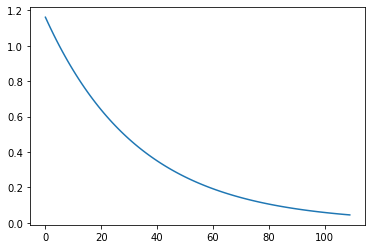

In [10]:
min_exploration_rate = 0.001
max_exploration_rate = 1.
exploration_decay_rate = 0.03
ers = []
for epoch in range(N_EPOCHS):
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*(epoch - EPOCH_TRAIN_START))
    ers.append(exploration_rate)
pd.Series(ers).plot()

### Pretrain Actor Network then commence RL training

Use the labels computed above to pretrain the actor network.  
All portfolio values [0, 1, 2] are trained to output logits that best suit the given labels.  

# TRY THE FOLLOWING WITHOUT PRETRAINING

In [ ]:
mlflow.set_experiment("A2C")
for dataset in datasets:
    for USE_MIDPRICE in [False, True]:
        # Fetch data
        X_train, X_val, X_test, y_train, y_val, y_test, bid_train, bid_val, bid_test, ask_train, ask_val, ask_test = [torch.load(path) for path in dataset]
        y_train, y_val, y_test = y_train.long(), y_val.long(), y_test.long()
        INPUT_DIMS = X_train.shape[-1]

        policy = ActorNetwork(input_dim=INPUT_DIMS, output_dim=OUTPUT_DIMS).to(device)
        critic = CriticNetwork(input_dim=INPUT_DIMS).to(device)
        critic_frozen = CriticNetwork(input_dim=INPUT_DIMS).to(device)
        critic_frozen.load_state_dict(critic.state_dict())
        
                
        # Begin logging
        with mlflow.start_run() as run:
            mlflow.log_params({
                'RL_algorithm': "A2C",
                'batch_size': BATCH_SIZE,
                'n_pretrain_epoch': N_PRETRAIN_EPOCH,
                'n_epochs': N_EPOCHS,
                'train_start_epoch': EPOCH_TRAIN_START,
                'learning_rate': LEARNING_RATE,
                'replay_memory_size': REPLAY_MEMORY_SIZE,
                'discount_rate': DISCOUNT_RATE,
                'frozen_update_interval': FROZEN_UPDATE_INTERVAL,
                'use_midprice': USE_MIDPRICE,
                'trading_fee': TRADING_FEE,
                'neutral_penalty': NEUTRAL_PENALTY,
                'market_open': MARKET_OPEN,
                'market_close': MARKET_CLOSE,
                'granularity': GRANULARITY,
                'month': MONTH,
                'datascope': dataset[0].split("/")[2],
                'device': device,
                'input_dims': INPUT_DIMS,
                'critic_loss_fn': 'MSE',
                'network_optimizer_fns': 'Adam',
                'pretrain_loss_fn': 'CrossEntropyLoss',
                'policy_network': str(policy.linear_stack).replace("in_features=", "").replace("out_features=", "").replace(" ", "").replace("\n", "").replace(",bias=True", ""),
                'critic_network': str(critic.linear_stack).replace("in_features=", "").replace("out_features=", "").replace(" ", "").replace("\n", "").replace(",bias=True", ""),
                'min_exploration_rate': min_exploration_rate,
                'max_exploration_rate': max_exploration_rate,
                'exploration_decay_rate': exploration_decay_rate,
            })

            policy.train()
            critic.train()
            critic_frozen.eval()

            policy_optimizer = optim.Adam(params=policy.parameters(), lr=LEARNING_RATE)
            critic_optimizer = optim.Adam(params=critic.parameters(), lr=LEARNING_RATE)

            mse_fn = nn.MSELoss()

            dataloader = DataLoader([(X_train[i], y_train[i]) for i in range(X_train.shape[0])], shuffle=True, batch_size=BATCH_SIZE)

            pretrain_loss_fn = nn.CrossEntropyLoss()
            pretrain_optimizer = optim.Adam(params=policy.parameters(), lr=LEARNING_RATE)

            for i in range(N_PRETRAIN_EPOCH):
                for batch, (X, y) in enumerate(dataloader):
                    X_dummy = X.clone()
                    X_dummy[..., -1] = i % 3

                    logits = policy(X_dummy, return_logits=True)
                    pretrain_loss = pretrain_loss_fn(logits, y.long())

                    # Backpropagation
                    pretrain_optimizer.zero_grad()
                    pretrain_loss.backward()
                    pretrain_optimizer.step()

                    if batch % 5 == 0:
                        print(f"Epoch: {i:2} Batch: {batch:3} of {len(dataloader)} Loss: {pretrain_loss.item():10.6f}", end="\r")
                mlflow.log_metric("pretrain_loss", pretrain_loss.item(), step=i)

            print("")

            critic_loss_history = []
            policy_loss_history = []
            reward_history = []
            replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE) # 2**20 values
            
            best_episode_reward = float("-inf")
            best_episode_validation_reward = float("-inf")

            for epoch in range(N_EPOCHS):
                policy.train()
                episode_action_history = []
                done = False
                episode_reward = 0
                state = X_train[0].clone()
                bid, ask = bid_train[0], ask_train[0]

                for i in range(1, X_train.shape[0]):
                    # Explore vs exploit
                    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*(epoch - EPOCH_TRAIN_START))
                    if random.uniform(0, 1) > exploration_rate:
                        action = policy(state) # Exploit
                    else:
                        action = torch.tensor(random.sample(ACTION_SPACE, 1)).to(device) # Explore

                    # Environment step
                    next_state = X_train[i].clone()
                    next_state[..., -1] = action
                    next_bid = bid_train[i]
                    next_ask = ask_train[i]

                    reward = get_reward(state, bid, ask, next_state, next_bid, next_ask, use_midprice=USE_MIDPRICE, trading_fee=TRADING_FEE, neutral_penalty=NEUTRAL_PENALTY)
                    done = i == (X_train.shape[0] - 1)

                    # Saves
                    replay_memory.push(Experience(state, action, reward, next_state, done))
                    episode_action_history.append(action.item())
                    episode_reward += reward
                    state = next_state
                    bid = next_bid
                    ask = next_ask

                    if replay_memory.can_provide_sample(BATCH_SIZE) and epoch > EPOCH_TRAIN_START:
                        states, actions, rewards, next_states, dones = replay_memory.sample(BATCH_SIZE)
                        states, actions, rewards, next_states, dones = states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)
                        actions = actions.long()
                        dones = dones.float()

                        # Error calculation
                        log_probs = policy.get_log_prob(states, actions)
                        q_values = critic(states).squeeze(-1)
                        q_target = (rewards + (1 - dones) * DISCOUNT_RATE * critic_frozen(next_states).squeeze(-1)).detach()
                        advantages = q_target - q_values

                        assert (log_probs <= 0).all(), "There cannot be positive log probabilities"

                        policy_loss = -(log_probs * advantages.detach()).mean()
                        value_loss = mse_fn(q_target, q_values)

                        # Optimization
                        critic_optimizer.zero_grad()
                        value_loss.backward()
                        critic_optimizer.step()

                        policy_optimizer.zero_grad()
                        policy_loss.backward()
                        policy_optimizer.step()

                reward_history.append(episode_reward) ######## LOG THE REWARD
                mlflow.log_metric("episode_reward", episode_reward, step=epoch)

                if replay_memory.can_provide_sample(BATCH_SIZE) and i % FROZEN_UPDATE_INTERVAL == 0 and epoch > EPOCH_TRAIN_START:
                    critic_frozen.load_state_dict(critic.state_dict())
                    critic_frozen.eval()

                if replay_memory.can_provide_sample(BATCH_SIZE) and epoch > EPOCH_TRAIN_START:
                        print(f"Epoch: {epoch:>5,d}, Reward: {episode_reward:>10,.6f}, Critic loss: {value_loss.item():>10,.6f}, Actor loss: {policy_loss.item():>10,.6f}", end="\r")
                        mlflow.log_metric("critic_loss", value_loss.item(), step=epoch)
                        mlflow.log_metric("actor_loss", policy_loss.item(), step=epoch)
                        
                        # Save episode action information - Need to see if the agent is changing its portfolio regularly
                        for k, v in dict(pd.Series(episode_action_history).value_counts()).items():
                            mlflow.log_metric(f"action_{k}", v, step=epoch)
                            
                if (episode_reward > best_episode_reward):
                    best_episode_reward = episode_reward
                    torch.save(policy.state_dict(), "best_train_policy_state_dict.pt")
                    torch.save(critic.state_dict(), "best_train_critic_state_dict.pt")
                    mlflow.log_artifact("best_train_policy_state_dict.pt")
                    mlflow.log_artifact("best_train_critic_state_dict.pt")
################
                with torch.no_grad():
                    # Validation checks
                    policy.eval()
                    val_state = X_val[0]
                    val_bid = bid_val[0]
                    val_ask = ask_val[0]
                    validation_reward = 0
                    validation_actions = []

                    for k in range(1, X_val.shape[0]):
                        val_action = policy(val_state)

                        val_next_state = X_val[k]
                        val_next_state[..., -1] = val_action

                        val_next_bid = bid_val[k]
                        val_next_ask = ask_val[k]

                        reward = get_reward(val_state, val_bid, val_ask, val_next_state, val_next_bid, val_next_ask, neutral_penalty=0)
                        validation_reward += reward
                        validation_actions.append(val_action.item())
                        val_state = val_next_state
                        val_bid = val_next_bid
                        val_ask = val_next_ask

                    mlflow.log_metric("validation_episode_reward", validation_reward, step=epoch)
                    for key, value in dict(pd.Series(validation_actions).value_counts()).items():
                        mlflow.log_metric(f"validation_action_{key}", value, step=epoch)

                    if validation_reward > best_episode_validation_reward:
                        best_episode_validation_reward = validation_reward
                        torch.save(policy.state_dict(), "best_val_policy_state_dict.pt")
                        torch.save(critic.state_dict(), "best_val_critic_state_dict.pt")
                        mlflow.log_artifact("best_val_policy_state_dict.pt")
                        mlflow.log_artifact("best_val_critic_state_dict.pt")
                    policy.train()

            torch.save(policy.state_dict(), "last_train_policy_state_dict.pt")
            torch.save(critic.state_dict(), "last_train_critic_state_dict.pt")
            mlflow.log_artifact("last_train_policy_state_dict.pt")
            mlflow.log_artifact("last_train_critic_state_dict.pt")
            

Epoch: 14 Batch:  25 of 29 Loss:   1.828516


## DDQN

In [ ]:
mlflow.set_experiment("Double DQN")
for dataset in datasets:
    for USE_MIDPRICE in [False, True]:
        # Fetch data
        X_train, X_val, X_test, y_train, y_val, y_test, bid_train, bid_val, bid_test, ask_train, ask_val, ask_test = [torch.load(path) for path in dataset]
        y_train, y_val, y_test = y_train.long(), y_val.long(), y_test.long()
        INPUT_DIMS = X_train.shape[-1]
        
        value_network = ValueNetwork(input_dim = INPUT_DIMS, output_dim = OUTPUT_DIMS).to(device)
        fixed_network = ValueNetwork(input_dim = INPUT_DIMS, output_dim = OUTPUT_DIMS).to(device)
        fixed_network.load_state_dict(value_network.state_dict())
        value_network.train()
        fixed_network.eval()
        
        value_optimizer = optim.Adam(params=value_network.parameters(), lr=LEARNING_RATE)
        mse_fn = nn.MSELoss()
        
        # Begin logging
        with mlflow.start_run() as run:
            mlflow.log_params({
                'batch_size': BATCH_SIZE,
                'n_epochs': N_EPOCHS,
                'train_start_epoch': EPOCH_TRAIN_START,
                'learning_rate': LEARNING_RATE,
                'replay_memory_size': REPLAY_MEMORY_SIZE,
                'discount_rate': DISCOUNT_RATE,
                'frozen_update_interval': FROZEN_UPDATE_INTERVAL,
                'use_midprice': USE_MIDPRICE,
                'trading_fee': TRADING_FEE,
                'neutral_penalty': NEUTRAL_PENALTY,
                'market_open': MARKET_OPEN,
                'market_close': MARKET_CLOSE,
                'granularity': GRANULARITY,
                'month': MONTH,
                'datascope': dataset[0].split("/")[2],
                'device': device,
                'input_dims': INPUT_DIMS,
                'critic_loss_fn': 'MSE',
                'network_optimizer_fns': 'Adam',
                'pretrain_loss_fn': 'CrossEntropyLoss',
                'policy_network': str(value_network.linear_stack).replace("in_features=", "").replace("out_features=", "").replace(" ", "").replace("\n", "").replace(",bias=True", ""),
                'min_exploration_rate': min_exploration_rate,
                'max_exploration_rate': max_exploration_rate,
                'exploration_decay_rate': exploration_decay_rate,
            })

            critic_loss_history = []
            policy_loss_history = []
            reward_history = []
            replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE) # 2**20 values
            
            best_episode_reward = float("-inf")
            best_episode_validation_reward = float("-inf")

            for epoch in range(N_EPOCHS):
                value_network.train()
                episode_action_history = []
                done = False
                episode_reward = 0
                state = X_train[0].clone()
                bid, ask = bid_train[0], ask_train[0]

                for i in range(1, X_train.shape[0]):
                    # Explore vs exploit
                    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*(epoch - EPOCH_TRAIN_START))
                    if random.uniform(0, 1) > exploration_rate:
                        value_network(state).argmax()
                    else:
                        action = torch.tensor(random.sample(ACTION_SPACE, 1)).to(device) # Explore

                    # Environment step
                    next_state = X_train[i].clone()
                    next_state[..., -1] = action
                    next_bid = bid_train[i]
                    next_ask = ask_train[i]

                    reward = get_reward(state, bid, ask, next_state, next_bid, next_ask, use_midprice=USE_MIDPRICE, trading_fee=TRADING_FEE, neutral_penalty=NEUTRAL_PENALTY)
                    done = i == (X_train.shape[0] - 1)

                    # Saves
                    replay_memory.push(Experience(state, action, reward, next_state, done))
                    episode_action_history.append(action.item())
                    episode_reward += reward
                    state = next_state
                    bid = next_bid
                    ask = next_ask

                    if replay_memory.can_provide_sample(BATCH_SIZE) and epoch > EPOCH_TRAIN_START:
                        states, actions, rewards, next_states, dones = replay_memory.sample(BATCH_SIZE)
                        states, actions, rewards, next_states, dones = states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)
                        actions = actions.long()
                        dones = dones.float()

                        # Error calculation
                        action_targets = value_network(next_states).max(dim=-1)[1].unsqueeze(-1)
                        target_values = rewards + (1 - dones) * DISCOUNT_RATE * fixed_network(next_states).gather(-1, action_targets).squeeze(-1) # Double DQN
                        # target_values = rewards + (1 - dones) * DISCOUNT_RATE * q_fn_frozen(next_states).max(dim=-1)[0] # DQN

                        current_values = value_network(states).gather(-1, actions.unsqueeze(-1)).squeeze(1)

                        # Loss
                        loss = mse_fn(current_values, target_values.detach())
                        value_optimizer.zero_grad()
                        loss.backward()
                        value_optimizer.step()

                reward_history.append(episode_reward) ######## LOG THE REWARD
                mlflow.log_metric("episode_reward", episode_reward, step=epoch)

                if replay_memory.can_provide_sample(BATCH_SIZE) and i % FROZEN_UPDATE_INTERVAL == 0 and epoch > EPOCH_TRAIN_START:
                    fixed_network.load_state_dict(value_network.state_dict())
                    fixed_network.eval()

                if replay_memory.can_provide_sample(BATCH_SIZE) and epoch > EPOCH_TRAIN_START:
                        print(f"Epoch: {epoch:>5,d}, Reward: {episode_reward:>10,.6f}, Value loss: {loss.item():>10,.6f}", end="\r")
                        mlflow.log_metric("train_value_network_loss", loss.item(), step=epoch)
                        
                        # Save episode action information - Need to see if the agent is changing its portfolio regularly
                        for k, v in dict(pd.Series(episode_action_history).value_counts()).items():
                            mlflow.log_metric(f"action_{k}", v, step=epoch)
                            
                if (episode_reward > best_episode_reward):
                    best_episode_reward = episode_reward
                    torch.save(value_network.state_dict(), "best_train_value_state_dict.pt")
                    mlflow.log_artifact("best_train_value_state_dict.pt")
################
                with torch.no_grad():
                    # Validation checks
                    value_network.eval()
                    val_state = X_val[0]
                    val_bid = bid_val[0]
                    val_ask = ask_val[0]
                    validation_reward = 0
                    validation_actions = []

                    for k in range(1, X_val.shape[0]):
                        val_action = value_network(val_state).argmax()

                        val_next_state = X_val[k]
                        val_next_state[..., -1] = val_action

                        val_next_bid = bid_val[k]
                        val_next_ask = ask_val[k]

                        reward = get_reward(val_state, val_bid, val_ask, val_next_state, val_next_bid, val_next_ask, neutral_penalty=0)
                        validation_reward += reward
                        validation_actions.append(val_action.item())
                        val_state = val_next_state
                        val_bid = val_next_bid
                        val_ask = val_next_ask

                    mlflow.log_metric("validation_episode_reward", validation_reward, step=epoch)
                    for key, value in dict(pd.Series(validation_actions).value_counts()).items():
                        mlflow.log_metric(f"validation_action_{key}", value, step=epoch)

                    if validation_reward > best_episode_validation_reward:
                        best_episode_validation_reward = validation_reward
                        torch.save(value_network.state_dict(), "best_val_value_state_dict.pt")
                        mlflow.log_artifact("best_val_value_state_dict.pt")
                    value_network.train()

            torch.save(value_network.state_dict(), "last_train_value_state_dict.pt")
            mlflow.log_artifact("last_train_value_state_dict.pt")
            

## DQN

Final report
- Describe RL
- Describe LOB
- What metric are we trying to optimise
- Inputs
- Literature review
- Results